# 03 - Domain Shift Generation

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/IvanNece/Detection-of-Anomalies-with-Localization/blob/main/notebooks/03_domain_shift_generation.ipynb)

**Steps 2.1 & 2.2**: Implement shift transformations and generate MVTec-Shift dataset

This notebook:
1. Tests and validates shift transformations
2. Generates the complete MVTec-Shift dataset by applying transforms to all splits
3. Saves transformed images and masks to `data/shifted/`

In [1]:
# Mount Drive and setup
from google.colab import drive
from pathlib import Path

drive.mount('/content/drive')

# Clone repository
!git clone https://github.com/IvanNece/Detection-of-Anomalies-with-Localization.git 2>/dev/null || echo "Repository already exists"

PROJECT_ROOT = Path('/content/Detection-of-Anomalies-with-Localization')
DATASET_PATH = Path('/content/drive/MyDrive/mvtec_ad')

print(f"Project: {PROJECT_ROOT}")
print(f"Dataset: {DATASET_PATH}")

Mounted at /content/drive
Project: /content/Detection-of-Anomalies-with-Localization
Dataset: /content/drive/MyDrive/mvtec_ad


In [2]:
import sys
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import torch

sys.path.insert(0, str(PROJECT_ROOT))

from src.utils.reproducibility import set_seed
from src.utils.config import Config
from src.data.transforms import get_clean_transforms, get_shift_transforms
from src.data.splitter import load_splits

%matplotlib inline
plt.style.use('seaborn-v0_8-darkgrid')

print("Imports loaded!")

Imports loaded!


## Configuration

In [3]:
config = Config.load(PROJECT_ROOT / 'configs' / 'experiment_config.yaml')
set_seed(config.seed)

print(f"Seed: {config.seed}")
print(f"Image size: {config.dataset.image_size}")
print(f"\nGeometric transforms: {config.domain_shift.geometric}")
print(f"\nPhotometric transforms: {config.domain_shift.photometric}")

Loaded configuration from /content/Detection-of-Anomalies-with-Localization/configs/experiment_config.yaml
Random seed set to 42 for reproducibility
Seed: 42
Image size: 224

Geometric transforms: Config({'rotation_range': [-10, 10], 'scale_range': [0.9, 1.0], 'aspect_ratio_range': [0.9, 1.1], 'translate_range': 0.1})

Photometric transforms: Config({'brightness_range': [0.7, 1.3], 'contrast_range': [0.7, 1.3], 'saturation_range': [0.7, 1.3], 'gaussian_blur': {'kernel_size': [3, 5], 'sigma_range': [0.1, 2.0]}, 'gaussian_noise': {'sigma_range': [0.01, 0.05]}})


## 1. Load Test Images

In [4]:
# Load splits
splits = load_splits(PROJECT_ROOT / 'data' / 'processed' / 'clean_splits.json')

# Get sample images: one normal and one anomalous from hazelnut test set
hazelnut_test = splits['hazelnut']['test']

# Find a normal image
normal_idx = [i for i, label in enumerate(hazelnut_test['labels']) if label == 0][0]
normal_img_path = hazelnut_test['images'][normal_idx]

# Find an anomalous image with mask (not None)
anomalous_indices = [i for i, (label, mask) in enumerate(zip(hazelnut_test['labels'], hazelnut_test['masks']))
                     if label == 1 and mask is not None]
if not anomalous_indices:
    print("Warning: No anomalous images with masks found, using first anomaly")
    anomalous_idx = [i for i, label in enumerate(hazelnut_test['labels']) if label == 1][0]
else:
    anomalous_idx = anomalous_indices[0]

anomalous_img_path = hazelnut_test['images'][anomalous_idx]
anomalous_mask_path = hazelnut_test['masks'][anomalous_idx]

print(f"Normal image: {Path(normal_img_path).name}")
print(f"Anomalous image: {Path(anomalous_img_path).name}")
print(f"Mask: {Path(anomalous_mask_path).name if anomalous_mask_path else 'None'}")


Normal image: 000.png
Anomalous image: 007.png
Mask: 007_mask.png


## 2. Test Clean vs Shift Transforms

In [5]:
# Create transforms
clean_transform = get_clean_transforms(
    image_size=config.dataset.image_size,
    normalize_mean=config.dataset.normalize.mean,
    normalize_std=config.dataset.normalize.std
)

shift_transform = get_shift_transforms(
    image_size=config.dataset.image_size,
    normalize_mean=config.dataset.normalize.mean,
    normalize_std=config.dataset.normalize.std,
    geometric_config=config.domain_shift.geometric.to_dict(),
    photometric_config=config.domain_shift.photometric.to_dict(),
    seed=config.seed
)

print("Transforms created!")

Transforms created!


## 3. Visualize: Normal Image (Clean vs Shifted)

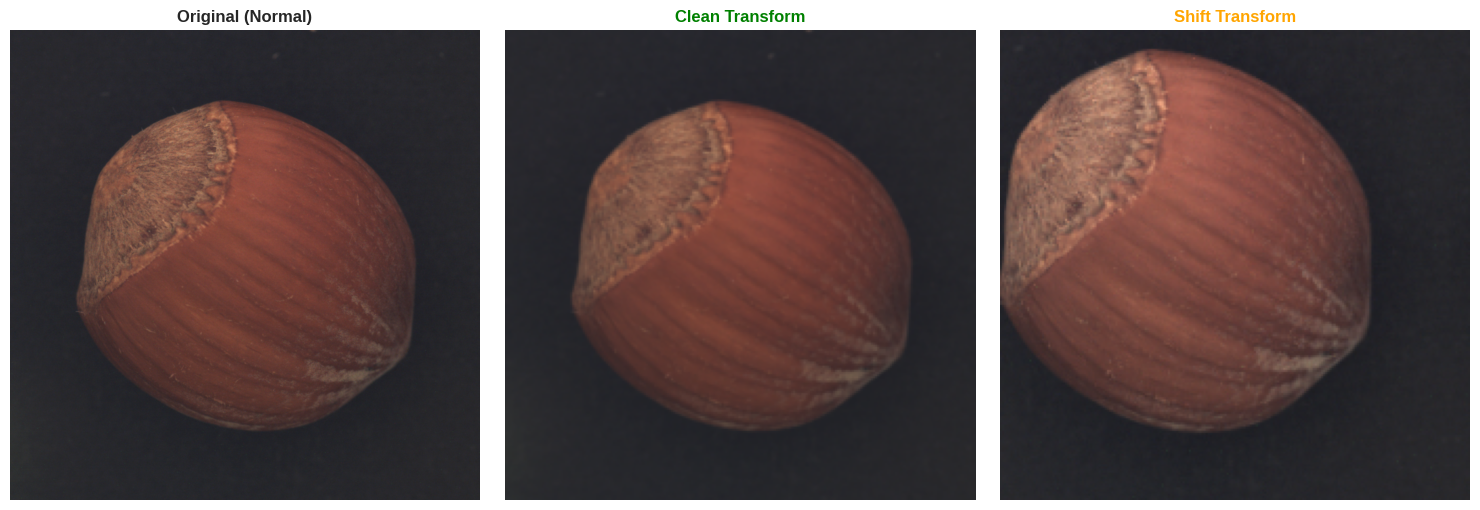

Notice the differences in: brightness, rotation, blur


In [6]:
def denormalize(tensor, mean, std):
    """Denormalize tensor for visualization."""
    tensor = tensor.clone()
    for t, m, s in zip(tensor, mean, std):
        t.mul_(s).add_(m)
    return torch.clamp(tensor, 0, 1)

# Load normal image
normal_img = Image.open(normal_img_path).convert('RGB')

# Apply transforms
normal_clean, _ = clean_transform(normal_img, None)
normal_shifted, _ = shift_transform(normal_img, None)

# Denormalize for visualization
normal_clean_vis = denormalize(normal_clean, config.dataset.normalize.mean, config.dataset.normalize.std)
normal_shifted_vis = denormalize(normal_shifted, config.dataset.normalize.mean, config.dataset.normalize.std)

# Plot
fig, axes = plt.subplots(1, 3, figsize=(15, 5))

axes[0].imshow(normal_img)
axes[0].set_title('Original (Normal)', fontsize=12, fontweight='bold')
axes[0].axis('off')

axes[1].imshow(normal_clean_vis.permute(1, 2, 0).numpy())
axes[1].set_title('Clean Transform', fontsize=12, fontweight='bold', color='green')
axes[1].axis('off')

axes[2].imshow(normal_shifted_vis.permute(1, 2, 0).numpy())
axes[2].set_title('Shift Transform', fontsize=12, fontweight='bold', color='orange')
axes[2].axis('off')

plt.tight_layout()
plt.show()

print("Notice the differences in: brightness, rotation, blur")

## 4. Visualize: Anomalous Image with Mask Alignment

✓ Masks remain aligned with defects after geometric transforms!


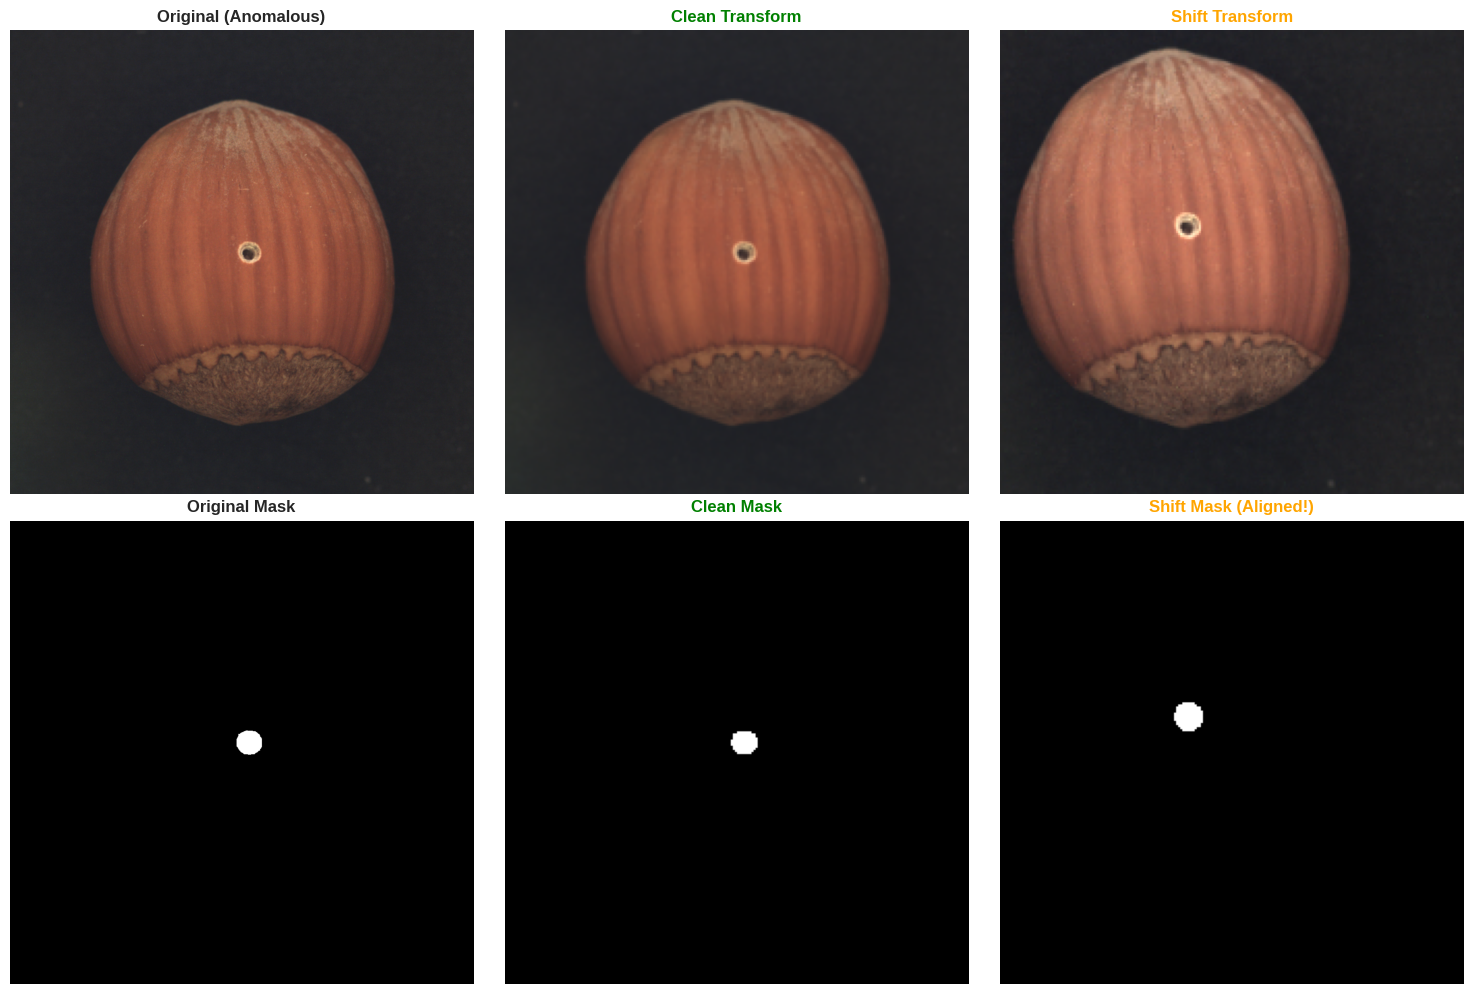

In [7]:
# Load anomalous image and mask
anomalous_img = Image.open(anomalous_img_path).convert('RGB')
if anomalous_mask_path:
    anomalous_mask = Image.open(anomalous_mask_path).convert('L')
else:
    # Create empty mask if None
    anomalous_mask = Image.new('L', anomalous_img.size, 0)
    print("Note: No mask found, using empty mask for visualization")

# Apply transforms
anom_clean, mask_clean = clean_transform(anomalous_img, anomalous_mask)
anom_shifted, mask_shifted = shift_transform(anomalous_img, anomalous_mask)

# Denormalize
anom_clean_vis = denormalize(anom_clean, config.dataset.normalize.mean, config.dataset.normalize.std)
anom_shifted_vis = denormalize(anom_shifted, config.dataset.normalize.mean, config.dataset.normalize.std)

# Plot
fig, axes = plt.subplots(2, 3, figsize=(15, 10))

# Row 1: Images
axes[0, 0].imshow(anomalous_img)
axes[0, 0].set_title('Original (Anomalous)', fontsize=12, fontweight='bold')
axes[0, 0].axis('off')

axes[0, 1].imshow(anom_clean_vis.permute(1, 2, 0).numpy())
axes[0, 1].set_title('Clean Transform', fontsize=12, fontweight='bold', color='green')
axes[0, 1].axis('off')

axes[0, 2].imshow(anom_shifted_vis.permute(1, 2, 0).numpy())
axes[0, 2].set_title('Shift Transform', fontsize=12, fontweight='bold', color='orange')
axes[0, 2].axis('off')

# Row 2: Masks
axes[1, 0].imshow(anomalous_mask, cmap='gray')
axes[1, 0].set_title('Original Mask', fontsize=12, fontweight='bold')
axes[1, 0].axis('off')

axes[1, 1].imshow(mask_clean.squeeze().numpy(), cmap='gray')
axes[1, 1].set_title('Clean Mask', fontsize=12, fontweight='bold', color='green')
axes[1, 1].axis('off')

axes[1, 2].imshow(mask_shifted.squeeze().numpy(), cmap='gray')
axes[1, 2].set_title('Shift Mask (Aligned!)', fontsize=12, fontweight='bold', color='orange')
axes[1, 2].axis('off')

print("✓ Masks remain aligned with defects after geometric transforms!")

plt.tight_layout()
plt.show()

## 5. Test Reproducibility

In [8]:
# Apply shift transform twice with same seed
shift_transform_1 = get_shift_transforms(
    image_size=config.dataset.image_size,
    normalize_mean=config.dataset.normalize.mean,
    normalize_std=config.dataset.normalize.std,
    geometric_config=config.domain_shift.geometric.to_dict(),
    photometric_config=config.domain_shift.photometric.to_dict(),
    seed=42
)

shift_transform_2 = get_shift_transforms(
    image_size=config.dataset.image_size,
    normalize_mean=config.dataset.normalize.mean,
    normalize_std=config.dataset.normalize.std,
    geometric_config=config.domain_shift.geometric.to_dict(),
    photometric_config=config.domain_shift.photometric.to_dict(),
    seed=42
)

img1, mask1 = shift_transform_1(anomalous_img, anomalous_mask)
img2, mask2 = shift_transform_2(anomalous_img, anomalous_mask)

# Check if tensors are identical
img_match = torch.allclose(img1, img2, atol=1e-6)
mask_match = torch.allclose(mask1, mask2, atol=1e-6)

print(f"Image reproducibility: {'✓' if img_match else '✗'}")
print(f"Mask reproducibility: {'✓' if mask_match else '✗'}")

if img_match and mask_match:
    print("\n✓ Shift transforms are perfectly reproducible with same seed!")
else:
    print("\n✗ Warning: Reproducibility issue detected!")

Image reproducibility: ✓
Mask reproducibility: ✓

✓ Shift transforms are perfectly reproducible with same seed!


## 6. Multiple Shift Examples

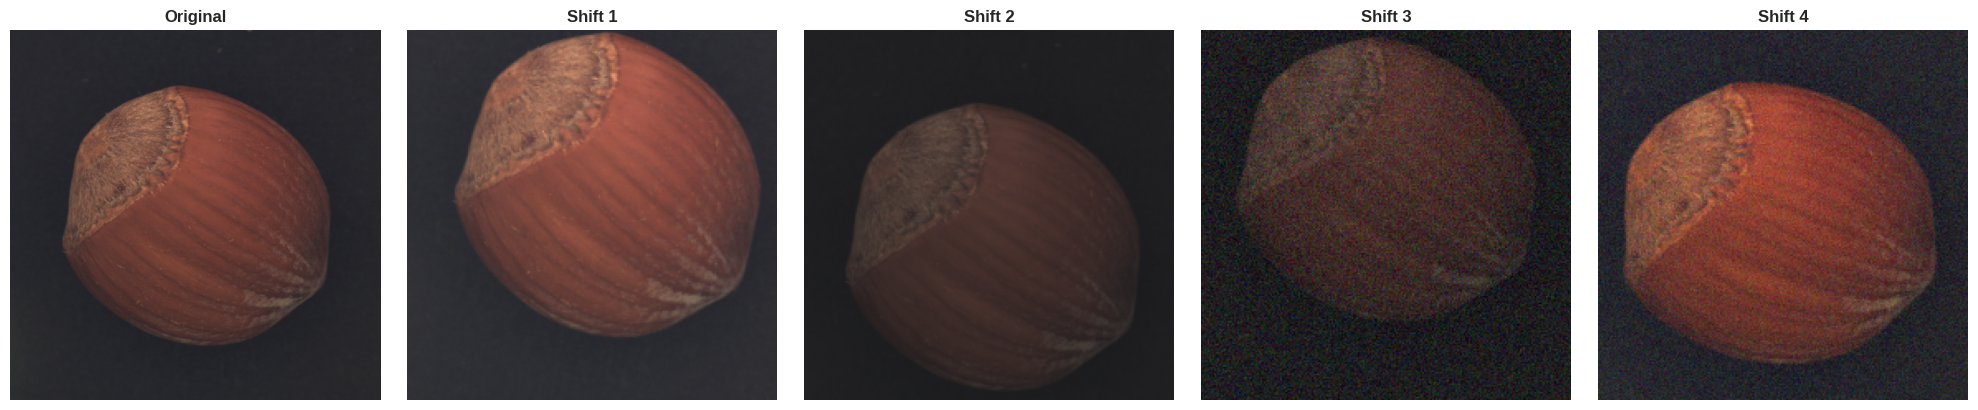

Each shift produces different but realistic variations


In [9]:
# Generate multiple shifted versions with different seeds
fig, axes = plt.subplots(1, 5, figsize=(20, 4))

axes[0].imshow(normal_img)
axes[0].set_title('Original', fontsize=12, fontweight='bold')
axes[0].axis('off')

for i in range(1, 5):
    shift_t = get_shift_transforms(
        image_size=config.dataset.image_size,
        normalize_mean=config.dataset.normalize.mean,
        normalize_std=config.dataset.normalize.std,
        geometric_config=config.domain_shift.geometric.to_dict(),
        photometric_config=config.domain_shift.photometric.to_dict(),
        seed=42 + i
    )
    img_shifted, _ = shift_t(normal_img, None)
    img_shifted_vis = denormalize(img_shifted, config.dataset.normalize.mean, config.dataset.normalize.std)

    axes[i].imshow(img_shifted_vis.permute(1, 2, 0).numpy())
    axes[i].set_title(f'Shift {i}', fontsize=12, fontweight='bold')
    axes[i].axis('off')

plt.tight_layout()
plt.show()

print("Each shift produces different but realistic variations")

---

# STEP 2.2: Generate MVTec-Shift Dataset

Now we apply shift transforms to all images in all splits and save them to disk.

## 7. Create Output Directory Structure

In [ ]:
import os
import shutil
from tqdm.auto import tqdm

# Define shifted dataset path
SHIFTED_PATH = PROJECT_ROOT / 'data' / 'shifted'

# Create directory structure
print("Creating directory structure for MVTec-Shift...")

for class_name in config.dataset.classes:
    for split in ['train', 'val', 'test']:
        # Images directory
        img_dir = SHIFTED_PATH / class_name / split / 'images'
        img_dir.mkdir(parents=True, exist_ok=True)

        # Masks directory
        mask_dir = SHIFTED_PATH / class_name / split / 'masks'
        mask_dir.mkdir(parents=True, exist_ok=True)

print(f"✓ Directory structure created at: {SHIFTED_PATH}")
print(f"  Classes: {', '.join(config.dataset.classes)}")
print(f"  Splits: train, val, test")

## 8. Generate Shifted Dataset - Apply Transforms to All Images

In [ ]:
import json
from PIL import Image

# Create shift transform
shift_transform = get_shift_transforms(
    image_size=config.dataset.image_size,
    normalize_mean=config.dataset.normalize.mean,
    normalize_std=config.dataset.normalize.std,
    geometric_config=config.domain_shift.geometric.to_dict(),
    photometric_config=config.domain_shift.photometric.to_dict(),
    seed=config.seed
)

# Initialize shifted splits dictionary
shifted_splits = {}
total_images = 0

print("Generating MVTec-Shift dataset...")
print("=" * 60)

for class_name in config.dataset.classes:
    print(f"\nProcessing class: {class_name.upper()}")
    shifted_splits[class_name] = {}

    for split in ['train', 'val', 'test']:
        print(f"  Split: {split}...")

        # Get original split data
        original_split = splits[class_name][split]
        n_images = len(original_split['images'])

        # Initialize lists for shifted split
        shifted_images = []
        shifted_masks = []
        shifted_labels = original_split['labels'].copy()

        # Process each image
        for idx in tqdm(range(n_images), desc=f"    {class_name}/{split}", leave=False):
            img_path = original_split['images'][idx]
            mask_path = original_split['masks'][idx]
            label = original_split['labels'][idx]

            # Load original image
            img = Image.open(img_path).convert('RGB')

            # Load mask if exists (anomalous samples)
            if mask_path:
                mask = Image.open(mask_path).convert('L')
            else:
                mask = None

            # Apply shift transform
            # NOTE: We need to SAVE the transformed image, not the normalized tensor
            # So we'll use a special version that doesn't normalize yet

            # Get original filename
            img_name = Path(img_path).name

            # Apply transform to get tensor (but we need to save image first)
            img_shifted_tensor, mask_shifted_tensor = shift_transform(img, mask)

            # We need to reverse the normalization and save the image
            # Better approach: apply geometric + photometric, save, then create tensor later
            # For now, let's denormalize and save

            img_shifted_vis = denormalize(
                img_shifted_tensor,
                config.dataset.normalize.mean,
                config.dataset.normalize.std
            )

            # Convert tensor back to PIL Image
            img_shifted_pil = Image.fromarray(
                (img_shifted_vis.permute(1, 2, 0).numpy() * 255).astype('uint8')
            )

            # Save shifted image
            shifted_img_path = SHIFTED_PATH / class_name / split / 'images' / img_name
            img_shifted_pil.save(shifted_img_path)
            shifted_images.append(str(shifted_img_path))

            # Save shifted mask if exists
            if mask_path:
                mask_shifted_pil = Image.fromarray(
                    (mask_shifted_tensor.squeeze().numpy() * 255).astype('uint8')
                )
                shifted_mask_path = SHIFTED_PATH / class_name / split / 'masks' / img_name
                mask_shifted_pil.save(shifted_mask_path)
                shifted_masks.append(str(shifted_mask_path))
            else:
                shifted_masks.append(None)

            total_images += 1

        # Store shifted split
        shifted_splits[class_name][split] = {
            'images': shifted_images,
            'masks': shifted_masks,
            'labels': shifted_labels
        }

        n_normal = sum(1 for l in shifted_labels if l == 0)
        n_anomalous = sum(1 for l in shifted_labels if l == 1)
        print(f"    ✓ {split}: {n_images} images ({n_normal} normal, {n_anomalous} anomalous)")

print("\n" + "=" * 60)
print(f"✓ MVTec-Shift dataset generated!")
print(f"  Total images processed: {total_images}")
print(f"  Saved to: {SHIFTED_PATH}")

## 9. Save Shifted Splits to JSON

In [ ]:
from src.data.splitter import save_splits

# Save shifted splits
shifted_splits_path = PROJECT_ROOT / 'data' / 'processed' / 'shifted_splits.json'

save_splits(
    splits=shifted_splits,
    output_path=shifted_splits_path,
    metadata={
        'domain': 'shifted',
        'seed': config.seed,
        'image_size': config.dataset.image_size,
        'transforms': {
            'geometric': config.domain_shift.geometric.to_dict(),
            'photometric': config.domain_shift.photometric.to_dict()
        },
        'source_splits': 'clean_splits.json'
    }
)

print(f"✓ Shifted splits saved to: {shifted_splits_path}")
print(f"  File size: {shifted_splits_path.stat().st_size / 1024:.2f} KB")

## 10. Verify Generated Dataset

In [ ]:
import os

print("Verifying MVTec-Shift dataset structure...")
print("=" * 60)

total_size = 0

for class_name in config.dataset.classes:
    print(f"\n{class_name.upper()}:")

    for split in ['train', 'val', 'test']:
        img_dir = SHIFTED_PATH / class_name / split / 'images'
        mask_dir = SHIFTED_PATH / class_name / split / 'masks'

        n_images = len(list(img_dir.glob('*.png'))) if img_dir.exists() else 0
        n_masks = len(list(mask_dir.glob('*.png'))) if mask_dir.exists() else 0

        # Calculate size
        if img_dir.exists():
            split_size = sum(f.stat().st_size for f in img_dir.glob('*.png'))
            if mask_dir.exists():
                split_size += sum(f.stat().st_size for f in mask_dir.glob('*.png'))
            total_size += split_size
        else:
            split_size = 0

        print(f"  {split:5s}: {n_images:3d} images, {n_masks:3d} masks ({split_size / (1024*1024):.1f} MB)")

print("\n" + "=" * 60)
print(f"✓ Total dataset size: {total_size / (1024*1024):.1f} MB")
print(f"✓ All files verified!")

## 11. Visualize Original vs Shifted Comparison

In [ ]:
# Compare original vs shifted for a few samples
fig, axes = plt.subplots(3, 4, figsize=(16, 12))

sample_count = 0
for class_idx, class_name in enumerate(config.dataset.classes):
    # Get one test sample (anomalous if possible)
    test_split = splits[class_name]['test']

    # Find anomalous sample
    anom_indices = [i for i, l in enumerate(test_split['labels']) if l == 1]
    if anom_indices:
        idx = anom_indices[0]
    else:
        idx = 0

    # Load original
    orig_img_path = test_split['images'][idx]
    orig_mask_path = test_split['masks'][idx]

    orig_img = Image.open(orig_img_path).convert('RGB')
    if orig_mask_path:
        orig_mask = Image.open(orig_mask_path).convert('L')
    else:
        orig_mask = Image.new('L', orig_img.size, 0)

    # Load shifted
    shifted_split = shifted_splits[class_name]['test']
    shifted_img_path = shifted_split['images'][idx]
    shifted_mask_path = shifted_split['masks'][idx]

    shifted_img = Image.open(shifted_img_path).convert('RGB')
    if shifted_mask_path:
        shifted_mask = Image.open(shifted_mask_path).convert('L')
    else:
        shifted_mask = Image.new('L', shifted_img.size, 0)

    # Plot
    axes[class_idx, 0].imshow(orig_img)
    axes[class_idx, 0].set_title(f'{class_name.upper()} - Original', fontweight='bold')
    axes[class_idx, 0].axis('off')

    axes[class_idx, 1].imshow(orig_mask, cmap='gray')
    axes[class_idx, 1].set_title('Original Mask', fontweight='bold')
    axes[class_idx, 1].axis('off')

    axes[class_idx, 2].imshow(shifted_img)
    axes[class_idx, 2].set_title(f'{class_name.upper()} - Shifted', fontweight='bold', color='orange')
    axes[class_idx, 2].axis('off')

    axes[class_idx, 3].imshow(shifted_mask, cmap='gray')
    axes[class_idx, 3].set_title('Shifted Mask', fontweight='bold', color='orange')
    axes[class_idx, 3].axis('off')

plt.tight_layout()
plt.show()

print("✓ Visual comparison shows domain shift effects on all classes")

## 12. Dataset Statistics Summary

In [ ]:
import pandas as pd

# Create statistics table
stats_data = []

for class_name in config.dataset.classes:
    for split in ['train', 'val', 'test']:
        split_data = shifted_splits[class_name][split]

        n_total = len(split_data['images'])
        n_normal = sum(1 for l in split_data['labels'] if l == 0)
        n_anomalous = sum(1 for l in split_data['labels'] if l == 1)
        n_masks = sum(1 for m in split_data['masks'] if m is not None)

        stats_data.append({
            'Class': class_name,
            'Split': split,
            'Total': n_total,
            'Normal': n_normal,
            'Anomalous': n_anomalous,
            'Masks': n_masks
        })

stats_df = pd.DataFrame(stats_data)

print("MVTec-Shift Dataset Statistics:")
print("=" * 70)
print(stats_df.to_string(index=False))
print("=" * 70)

# Summary by split
print("\nSummary by Split:")
summary = stats_df.groupby('Split')[['Total', 'Normal', 'Anomalous', 'Masks']].sum()
print(summary)

print(f"\n✓ Total images in MVTec-Shift: {stats_df['Total'].sum()}")

## 13. Save to Google Drive

In [ ]:
# Backup shifted dataset to Google Drive
import shutil

BACKUP_DIR = Path('/content/drive/MyDrive/mvtec_shift_backup')
BACKUP_DIR.mkdir(parents=True, exist_ok=True)

print("Backing up MVTec-Shift dataset to Google Drive...")
print(f"Source: {SHIFTED_PATH}")
print(f"Destination: {BACKUP_DIR}")
print("\nThis may take a few minutes...")

# Copy shifted splits JSON
shutil.copy2(shifted_splits_path, BACKUP_DIR / 'shifted_splits.json')
print("✓ shifted_splits.json copied")

# Create zip of shifted dataset
zip_path = BACKUP_DIR / 'mvtec_shifted_dataset'
shutil.make_archive(str(zip_path), 'zip', str(SHIFTED_PATH))
print(f"✓ Dataset zipped: {zip_path}.zip")

zip_size = (BACKUP_DIR / 'mvtec_shifted_dataset.zip').stat().st_size / (1024*1024)
print(f"\n✓ Backup complete! Size: {zip_size:.1f} MB")
print(f"✓ Location: {BACKUP_DIR}")

---

### 📁 Output Files:
- `data/shifted/` - Complete shifted dataset (~100-150 MB)
- `data/processed/shifted_splits.json` - Split definitions
- Google Drive backup (optional)
